<h1 style = "text-align: center;">Web Scraping and Exploratory Data Analysis of IMDB Top 250 Movies
</h1>
<p><b>Steps followed in this project :</b></p>
<ul>
  <li>Scraping data of IMDB Top 250 movies.</li>
  <li>Cleaning and organizing data with Pandas for analysis.</li>
  <li>Conducting EDA and Visualization for clear insights.</li>
  <li>Delivering a clean, structured dataset and actionable Insights & Observations.</li>
</ul>

## Scraping data of IMDB Top 250 movies.

In this step, we will scrape detailed information about the **IMDB Top 250 movies**.  
We are using the official IMDB website to scrape the data we want, while additional data will be collected from each movie's individual page.

The final dataset will include :
- Title  
- Release Year  
- IMDB Rating  
- Votes  
- Genre  
- Certificate (e.g., A, UA)  
- Runtime  
- Director  
- Main Cast (Stars)  
- Budget  
- Gross Revenue  

**Tools used** to scrape the data :
- `requests` - To send HTTP requests and retrieve webpage content.
- `BeautifulSoup` - To parse and extract structured information.
- `json` - To extract json information
- `Pandas` - To store, clean, and analyze the scraped data.
 

In [1]:
# importing the libraries
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# url and User-Agent
url = "https://www.imdb.com/chart/top" # this is the base url
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/140.0.0.0 Safari/537.36"
}                                      # user-agent is needed for authorization

In [3]:
# requesting using requests module
response = requests.get(url, headers = headers)
# Check if request worked
print(response.status_code)  # Should print 200
print(response)

200
<Response [200]>


In [4]:
# Parsing data using BeautifulSoup 
soup = BeautifulSoup(response.text, "html.parser") 

Now our HTML data is ready for Scraping

we will scrape each column shown above

In [5]:
# Extracting all 250 movie URLs from the JSON

# Locating the <script> tag that contains the movie data
script_tag = soup.find("script", attrs={"type": "application/ld+json"})

# Converting the JSON text inside the <script> tag to a Python dictionary
movie_data = json.loads(script_tag.text)

# Extracting URLs of all 250 movies
movie_urls = [movie["item"]["url"] for movie in movie_data["itemListElement"]]
print(len(movie_urls))

250


In [6]:
# This is how the data looks for each movie :-

# Looping through each movie URL
for i in movie_urls:
    # Sending a GET request for the movie page
    response = requests.get(i, headers = headers)
    print(f"Response : {response}\n") # Checking the response 
    
    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser") 
    
    # Getting the dataset :-
    
    # Extracting the json file for - Title, IMDB Rating, Votes, Genre, Release year, Certificate, Runtime
    data = json.loads(soup.find("script", attrs = {"type":"application/ld+json"}).text)
    
    # Extract the values from the json 
    print("Title : ", data["name"])                                              # Title
    print("IMDB Rating :", int(data["aggregateRating"]["ratingValue"]))          # IMDB Rating
    print("Votes :", int(data["aggregateRating"]["ratingCount"]))                # Votes 
    print("Genre :", ", ".join(data["genre"]))                                   # Genre 
    print("Release year :", int(data["datePublished"][:4]))                      # Release year
    print("Certificate :", data["contentRating"])                                # Certificate
    print("Runtime :", data["duration"][2:])                                     # Runtime
    
    # Extract values from scraping the page 
    # Director
    print("Director :", soup.find("a", attrs = {"class":"ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link"}).text)
    # Main Cast (Stars)
    print("Main Cast (Stars) :", ", ".join([i.text for i in soup.find_all("ul", attrs = {"class":"ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content baseAlt"})[2]]))
    # Budget
    print("Budget : ", int(soup.find_all("span", attrs = {"class" : "ipc-metadata-list-item__list-content-item ipc-btn--not-interactable"})[2].text.replace('$', '').replace(',', '').replace('(estimated)', '').strip()))
    # Gross Revenue
    print("Gross Revenue: ", int(soup.find_all("span", attrs = {"class" : "ipc-metadata-list-item__list-content-item ipc-btn--not-interactable"})[6].text.replace('$', '').replace(',', '').replace('(estimated)', '').strip()))

    # Run only for the first movie
    break

Response : <Response [200]>

Title :  The Shawshank Redemption
IMDB Rating : 9
Votes : 3098341
Genre : Drama
Release year : 1994
Certificate : A
Runtime : 2H22M
Director : Frank Darabont
Main Cast (Stars) : Tim Robbins, Morgan Freeman, Bob Gunton
Budget :  25000000
Gross Revenue:  29334033


The above code demonstrates how we extract data from a **single movie URL**.
These extracted fields represent the columns we want in our final DataFrame.

Now, we will repeat this process for **all 250 movies** and store the results in a **Pandas DataFrame**.

In [7]:
# Extracting all the fields for 250 movies :- 

# importing time module for creating time delay
import time

# Put the data into list format
Title = []
Release_year = [] 
IMDB_Rating = [] 
Votes = []
Genre = []
Certificate = []  
Runtime = []
Director = []
Main_Cast = []  
Budget = []
Gross_Revenue = []

# count the response success and failure to check of all the 250 movie data is extracted or not
response_success = 0
response_failure = 0

# Looping through each movie URL
for i in movie_urls:
    try:
        response = requests.get(i, headers=headers, timeout=10)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {i}: {e}")
        response_failure += 1
        continue  # Skip to the next movie

    time.sleep(1)  # Pause to avoid throttling
    
    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser") 
    
    # Getting the dataset :-
    
    # Extracting the json file for - Title, IMDB Rating, Votes, Genre, Release year, Certificate, Runtime
    data = json.loads(soup.find("script", attrs = {"type":"application/ld+json"}).text)
    
    # Extract the values from the json, if Not json then HTML <tag>, else it is Null
    
    # Title
    if bool(data.get("name")):                                                   
        Title.append(data["name"])
    elif bool(soup.find("span", attrs = {"class":"hero__primary-text"})):
        Title.append(soup.find("span", attrs = {"class":"hero__primary-text"}).text)
    else:
        Title.append(None)
        
    # IMDB Rating
    if bool(data.get("aggregateRating").get("ratingValue")):                                                   
        IMDB_Rating.append(float(data["aggregateRating"]["ratingValue"])) 
    elif bool(soup.find("div", attrs = {"class":"sc-4dc495c1-2 jaffDQ"})):
        IMDB_Rating.append(float(soup.find("div", attrs = {"class":"sc-4dc495c1-2 jaffDQ"}).text[:3]))
    else:
        IMDB_Rating.append(None)
        
        
    # Votes 
    if bool(data.get("aggregateRating").get("ratingCount")):                     
        Votes.append(int(data["aggregateRating"]["ratingCount"]))  
    elif bool(soup.find("span", attrs = {"class":"vote-count"})):
        Votes.append(int(float(soup.find("span", attrs = {"class":"vote-count"}).text[:-1])*1000))
    else:
        Votes.append(None)
    
    
    # Genre 
    if bool(data.get("genre")):                                                  
        Genre.append(", ".join(data["genre"]))    
    else:
        Genre.append(None)
        
    # Release year
    if bool(data.get("datePublished")):                                         
        Release_year.append(int(data["datePublished"][:4]))   
    elif len(soup.find_all("a", attrs={"class": "ipc-link ipc-link--baseAlt ipc-link--inherit-color"})) > 6:
        Release_year.append(int(soup.find_all("a", attrs={"class": "ipc-link ipc-link--baseAlt ipc-link--inherit-color"})[5].text))
    else:
        Release_year.append(None)
        
    # Certificate
    if bool(data.get("contentRating")):                                          
        Certificate.append(data["contentRating"])       
    elif len(soup.find_all("a", attrs={"class": "ipc-link ipc-link--baseAlt ipc-link--inherit-color"})) > 6:
        Certificate.append(soup.find_all("a", attrs={"class": "ipc-link ipc-link--baseAlt ipc-link--inherit-color"})[6].text)
    else:
        Certificate.append(None)
        
    # Runtime
    if bool(data.get("duration")):                                               
        Runtime.append(data["duration"][2:])                   
    elif len(soup.find_all("span", attrs = {"class":"ipc-metadata-list-item__list-content-item ipc-btn--not-interactable"})) > 8:
        Runtime.append(soup.find_all("span", attrs = {"class":"ipc-metadata-list-item__list-content-item ipc-btn--not-interactable"})[7].text)
    else:
        Runtime.append(None)


    
    # Handling Missing or Inconsistent Data Using try/except Blocks (These are not present in json)
    # Director, Main Cast (Stars), Budget, Gross Revenue
    
    # Director
    try:
        Director.append(soup.find("a", attrs = {"class":"ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link"}).text)
    except:
        Director.append(None)
    # Main Cast (Stars)
    try:
        Main_Cast.append(", ".join([i.text for i in soup.find_all("ul", attrs = {"class":"ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content baseAlt"})[2]]))
    except:
        Main_Cast.append(None)
    # Budget
    try:
        Budget.append(int(soup.find_all("span", attrs = {"class" : "ipc-metadata-list-item__list-content-item ipc-btn--not-interactable"})[2].text.replace('$', '').replace(',', '').replace('(estimated)', '').strip()))
    except:
        Budget.append(0)
    # Gross Revenue
    try:
        Gross_Revenue.append(int(soup.find_all("span", attrs = {"class" : "ipc-metadata-list-item__list-content-item ipc-btn--not-interactable"})[6].text.replace('$', '').replace(',', '').replace('(estimated)', '').strip()))
    except:
        Gross_Revenue.append(0)
        
      
    # Count the response success and failure
    if response.ok:
        response_success += 1
    else:
        response_failure += 1
        
print(f"Number of response success out of 250 : {response_success}")
print(f"Number of response failure out of 250 : {response_failure}")
    

Number of response success out of 250 : 250
Number of response failure out of 250 : 0


In [8]:
# Preview of Scraped Data
# Displaying the first 5 records from each list

# Movie Titles
print("Titles:", Title[:5])
# Release Year
print("Release Year:", Release_year[:5])
# IMDB Ratings
print("IMDB Rating:", IMDB_Rating[:5])
# Total Votes
print("Votes:", Votes[:5])
# Movie Genres
print("Genres:", Genre[:5])
# Certificates (e.g., PG, R)
print("Certificates:", Certificate[:5])
# Runtime of movies
print("Runtime:", Runtime[:5])
# Director names
print("Directors:", Director[:5])
# Main Cast
print("Main Cast:", Main_Cast[:5])
# Movie Budget
print("Budget ($):", Budget[:5])
# Worldwide Gross Revenue
print("Gross Revenue ($):", Gross_Revenue[:5])

Titles: ['The Shawshank Redemption', 'The Godfather', 'The Dark Knight', 'The Godfather Part II', '12 Angry Men']
Release Year: [1994, 1972, 2008, 1974, 1957]
IMDB Rating: [9.3, 9.2, 9.1, 9.0, 9.0]
Votes: [3098341, 2159397, 3073328, 1451377, 948037]
Genres: ['Drama', 'Crime, Drama', 'Action, Crime, Drama', 'Crime, Drama', 'Crime, Drama']
Certificates: ['A', 'A', 'UA', 'A', 'U']
Runtime: ['2H22M', '2H55M', '2H32M', '3H22M', '1H36M']
Directors: ['Frank Darabont', 'Francis Ford Coppola', 'Christopher Nolan', 'Francis Ford Coppola', 'Sidney Lumet']
Main Cast: ['Tim Robbins, Morgan Freeman, Bob Gunton', 'Marlon Brando, Al Pacino, James Caan', 'Christian Bale, Heath Ledger, Aaron Eckhart', 'Al Pacino, Robert De Niro, Robert Duvall', 'Henry Fonda, Lee J. Cobb, Martin Balsam']
Budget ($): [25000000, 6000000, 185000000, 13000000, 350000]
Gross Revenue ($): [29334033, 250342198, 1009242873, 48005720, 0]


Now the data will be saved as `IMDB_Top_250_Movies.csv` for further use.

In [12]:
# Creating a Pandas DataFrame for IMDB Top 250 Movies

# Combine all scraped lists into a structured DataFrame "imdb_df"

imdb_df = pd.DataFrame({
    "Title": Title,                 # Movie title
    "Release year": Release_year,   # Year of release
    "IMDB Rating": IMDB_Rating,     # IMDB rating
    "Votes": Votes,                 # Number of votes
    "Genre": Genre,                 # Movie genres
    "Certificate": Certificate,     # Film certificate (e.g., A, UA)
    "Runtime": Runtime,             # Duration of the movie
    "Director": Director,           # Director name
    "Main Cast": Main_Cast,         # Lead actors
    "Budget": Budget,               # Estimated production budget
    "Gross Revenue": Gross_Revenue  # Total worldwide gross revenue
})

# Display the resulting DataFrame
imdb_df.head(5)


,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime,Director,Main Cast,Budget,Gross Revenue
0,The Shawshank Redemption,1994.0,9.3,3098341,Drama,A,2H22M,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033
1,The Godfather,1972.0,9.2,2159397,"Crime, Drama",A,2H55M,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198
2,The Dark Knight,2008.0,9.1,3073328,"Action, Crime, Drama",UA,2H32M,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873
3,The Godfather Part II,1974.0,9.0,1451377,"Crime, Drama",A,3H22M,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall",13000000,48005720
4,12 Angry Men,1957.0,9.0,948037,"Crime, Drama",U,1H36M,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam",350000,0


In [13]:
# Save the DataFrame as a CSV file
imdb_df.to_csv("IMDB_Top_250_Movies.csv", index=False)

print("Data saved to IMDB_Top_250.csv successfully.")

Data saved to IMDB_Top_250.csv successfully.


Data has been saved as `IMDB_Top_250_Movies.csv`.

In the next stage, we will perform **Data cleaning** using **Pandas** before moving on to **Exploratory Data Analysis (EDA)**.

## Cleaning and organizing data with Pandas for analysis.

In this stage, we will prepare the raw IMDb dataset for analysis by handling missing values, correcting inconsistencies, and transforming data into a structured format.

This ensures the dataset is accurate, consistent, and ready for exploratory data analysis (EDA) and visualization.

In [233]:
# importing the libraries
import numpy as np
import pandas as pd

In [234]:
# Read the file "IMDB_Top_250_Movies.csv"
df = pd.read_csv("IMDB_Top_250_Movies.csv")

In [235]:
# Top 5 rows
df.head(5)

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime,Director,Main Cast,Budget,Gross Revenue
0,The Shawshank Redemption,1994.0,9.3,3098341,Drama,A,2H22M,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033
1,The Godfather,1972.0,9.2,2159397,"Crime, Drama",A,2H55M,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198
2,The Dark Knight,2008.0,9.1,3073328,"Action, Crime, Drama",UA,2H32M,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873
3,The Godfather Part II,1974.0,9.0,1451377,"Crime, Drama",A,3H22M,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall",13000000,48005720
4,12 Angry Men,1957.0,9.0,948037,"Crime, Drama",U,1H36M,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam",350000,0


In [236]:
# Checking for null values in each column
for col in df.columns:                 # Loop through each column in the DataFrame
    null_count = df[col].isna().sum()  # Count the number of null (NaN) values
    if null_count > 0:                 # Only print if there are null values
        print(f'{col} has : ({null_count}) null values')

# Observation: only the "Certificate" column has null values

Certificate has : (2) null values


In [237]:
# Identify which rows have null values in Certificate
df[df["Certificate"].isna()]

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime,Director,Main Cast,Budget,Gross Revenue
79,Das Boot,1981.0,8.4,282131,"Drama, War",NaN,2H29M,Wolfgang Petersen,"Jürgen Prochnow, Herbert Grönemeyer, Klaus Wen...",0,11489051
130,Hababam Sinifi: Sinifta Kaldi,1975.0,8.6,28187,Comedy,NaN,1H35M,Ertem Egilmez,"Münir Özkul, Tarik Akan, Kemal Sunal",0,0


In [238]:
# we can see there are values as "Not Rated" 
df["Certificate"].value_counts()
# So we can fill missing values with "Not Rated"

U            77
A            71
UA           50
R            12
Not Rated     8
Approved      8
Passed        5
G             4
PG            3
7             3
18            3
13            1
15+           1
UA 13+        1
16            1
Name: Certificate, dtype: int64

In [239]:
# Fill missing Certificate values with "Not Rated"
df["Certificate"] = df["Certificate"].fillna("Not Rated")

In [240]:
# Now the value count of "Not Rated" has raised from 8 to 10
df["Certificate"].value_counts()["Not Rated"]

10

In [241]:
# Verify that there are no null values remaining
df["Certificate"].isna().sum()

0

In [242]:
df["Certificate"].unique()

array(['A', 'UA', 'U', 'PG', '13', 'Not Rated', 'R', 'G', 'Approved', '7',
       '18', '15+', 'Passed', 'UA 13+', '16'], dtype=object)

Now the data has no NULL values

In [243]:
# Check for duplicates: "Title"
df["Title"].duplicated().sum()
# Observation: "Title" has no duplicates

0

In [244]:
# Confirm data type is integer: "Release year"
print(df["Release year"].dtype) # output: float64

# convert it to int
df["Release year"] = df["Release year"].astype(int)

float64


In [245]:
print(df["Release year"].dtype) # output: int32
df["Release year"].head()

int32


0    1994
1    1972
2    2008
3    1974
4    1957
Name: Release year, dtype: int32

In [246]:
# Checking the datatype for columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          250 non-null    object 
 1   Release year   250 non-null    int32  
 2   IMDB Rating    250 non-null    float64
 3   Votes          250 non-null    int64  
 4   Genre          250 non-null    object 
 5   Certificate    250 non-null    object 
 6   Runtime        250 non-null    object 
 7   Director       250 non-null    object 
 8   Main Cast      250 non-null    object 
 9   Budget         250 non-null    int64  
 10  Gross Revenue  250 non-null    int64  
dtypes: float64(1), int32(1), int64(3), object(6)
memory usage: 20.6+ KB


In [247]:
# Removing extra spaces: "Genre"
df["Genre"] = df["Genre"].str.strip()

For now, just cleaned the **Genre** column by stripping extra spaces.

This keeps it simple and avoids unnecessary complexity at this stage.

So that later in the **EDA** if we want to analyze which genres are most common, we can split them into list format.

In [248]:
# Checking the "Runtime" column
df["Runtime"].head()
# we can see the this data is not ideal for "EDA"

0    2H22M
1    2H55M
2    2H32M
3    3H22M
4    1H36M
Name: Runtime, dtype: object

SO, we will convet the Runtime to Minutes

The Runtime column currently contains values in mixed formats such as:

* "3H22M" → 3 hours 22 minutes
* "2H" → 2 hours only
* "59M" → 59 minutes only

For analysis, it's better to have this as a single numeric value (total **minutes**).

We will create a custom function `convert_runtime()` that will:

1. Extracts hours and minutes from the string.

2. Converts the entire runtime to minutes using the formula: 

    - Total Minutes = (Hours × 60) + Minutes 

Finally, we'll apply this function to the Runtime column using pandas `.apply()` method.

In [249]:
# This custom function "convert_runtime()" will change the data to minutes.

def convert_runtime(runtime):
    runtime = runtime.strip()  # Remove any extra spaces 
    # Variables for storing Integers
    hours = 0
    minutes = 0

    # If runtime contains hours
    if "H" in runtime:
        h_index = runtime.index("H")          # Position of 'H'
        hours = int(runtime[:h_index])        # Extract hours
        # If minutes also exist after hours
        if "M" in runtime:
            m_index = runtime.index("M")                 # Position of 'M'
            minutes = int(runtime[h_index + 1:m_index])  # Extract minutes

    # If only minutes exist
    else:
        m_index = runtime.index("M")
        minutes = int(runtime[:m_index])

    return hours * 60 + minutes # returns the value in minutes


In [250]:
# We can see the data is converted to minutes
df["Runtime"].apply(convert_runtime).head()

0    142
1    175
2    152
3    202
4     96
Name: Runtime, dtype: int64

In [251]:
# Apply to the DataFrame
df["Runtime"] = df["Runtime"].apply(convert_runtime)

In [252]:
# "Runtime" data has changed 
df["Runtime"].head()

0    142
1    175
2    152
3    202
4     96
Name: Runtime, dtype: int64

In [253]:
# Changing the column name from "Rumtime" to "Runtime (min)" to reflect the new format
df.rename(columns={"Runtime" : "Runtime (min)"}, inplace=True)

In [217]:
df.head(3)

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue
0,The Shawshank Redemption,1994,9.3,3098341,Drama,A,142,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033
1,The Godfather,1972,9.2,2159397,"Crime, Drama",A,175,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198
2,The Dark Knight,2008,9.1,3073328,"Action, Crime, Drama",UA,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873


Now we will change values of Budget and Gross Revenue from 0 to "NaN".

**0 in Budget and Gross Revenue means data is missing, not truly zero**.

So, we replace these 0s with "NaN" for accurate analysis.

In [255]:
# Replacing 0 with NaN in Budget and Gross Revenue
df["Budget"] = df["Budget"].replace(0, np.nan).astype("Int64")
df["Gross Revenue"] = df["Gross Revenue"].replace(0, np.nan).astype("Int64")

In [271]:
# Data is changed from 0 to NA
print("Budget Data :")
print(df["Budget"].tail())
print("\n")
print("Gross Revenue Data :")
print(df["Gross Revenue"].tail())

Budget Data :
245    15000000
246        <NA>
247    25000000
248     9400000
249    14600000
Name: Budget, dtype: Int64


Gross Revenue Data :
245     56676733
246         <NA>
247    221802186
248         <NA>
249     71108778
Name: Gross Revenue, dtype: Int64


**Adding Profit Column** :

Profit column will help for better analysis.

We calculate Profit for each movie by subtracting Budget from Gross Revenue.

If either value is missing (NaN), the Profit will also be (NaN).

In [289]:
# Create a new 'Profit' column
df['Profit'] = df['Gross Revenue'] - df['Budget']

# Display first 5 rows to verify
df[['Title', 'Budget', 'Gross Revenue', 'Profit']].head(5)

,Title,Budget,Gross Revenue,Profit
0,The Shawshank Redemption,25000000,29334033,4334033
1,The Godfather,6000000,250342198,244342198
2,The Dark Knight,185000000,1009242873,824242873
3,The Godfather Part II,13000000,48005720,35005720
4,12 Angry Men,350000,<NA>,<NA>


In [293]:
# Our data is clean now
df.head(3) 

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue,Profit
0,The Shawshank Redemption,1994,9.3,3098341,Drama,A,142,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033,4334033
1,The Godfather,1972,9.2,2159397,"Crime, Drama",A,175,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198,244342198
2,The Dark Knight,2008,9.1,3073328,"Action, Crime, Drama",UA,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873,824242873


In [294]:
# Save the cleaned dataset as "IMDB_Top_250_Movies_Cleaned.csv"
df.to_csv("IMDB_Top_250_Movies_Cleaned.csv", index=False)

print("Cleaned dataset saved as 'IMDB_Top_250_Movies_Cleaned.csv'")

Cleaned dataset saved as 'IMDB_Top_250_Movies_Cleaned.csv'


We now have a cleaned dataset saved as `IMDB_Top_250_Movies_Cleaned.csv`, which is the processed version of the raw data file `IMDB_Top_250_Movies.csv`.

All further **Exploratory Data Analysis (EDA)** will be performed on `IMDB_Top_250_Movies_Cleaned.csv`.

## Conducting EDA and Visualization for clear insights.

The goal of this stage is to explore, understand, and visualize the IMDb Top 250 Movies dataset.
EDA helps us:

* Identify patterns, trends, and relationships within the data.
* Detect missing values, outliers, or inconsistencies that could affect analysis.
* Summarize key statistics for both numerical and categorical variables.
* Create visualizations to communicate insights effectively.

**Key Focus Areas :-**

1. Dataset Structure :
    - Understand column data types and basic information.
    - Check for null values and their distribution.
2. Descriptive Statistics :
    - Summary of numerical variables like Budget, Gross Revenue, IMDB Rating, Votes, etc.
3. Single Column Analysis (one column at a time) :
    - Explore each column with counts, distributions, and visualizations.
4. Relationship Analysis (relationship between two columns) :
    - Identify correlations, trends, and patterns between numerical and categorical columns.


In [2]:
# importing the libraries

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

We will load the dataset we cleaned earlier `IMDB_Top_250_Movies_Cleaned.csv` and take a peek at the first few rows.

In [36]:
# Load the cleaned dataset
df = pd.read_csv("IMDB_Top_250_Movies_Cleaned.csv")

Pandas converts columns with NaN to float.
We will change Budget and Gross Revenue to nullable integers (Int64) to keep them as proper integers while allowing missing values.

Dataset Structure : Understand column data types and basic information.

In [37]:
# changing these columns datatype to "Int64"
df["Budget"] = df["Budget"].astype("Int64")
df["Gross Revenue"] = df["Gross Revenue"].astype("Int64")
df["Profit"] = df["Profit"].astype("Int64")

In [38]:
# Display the first 5 rows
df.head()

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue,Profit
0,The Shawshank Redemption,1994,9.3,3098341,Drama,A,142,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033,4334033
1,The Godfather,1972,9.2,2159397,"Crime, Drama",A,175,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198,244342198
2,The Dark Knight,2008,9.1,3073328,"Action, Crime, Drama",UA,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873,824242873
3,The Godfather Part II,1974,9.0,1451377,"Crime, Drama",A,202,Francis Ford Coppola,"Al Pacino, Robert De Niro, Robert Duvall",13000000,48005720,35005720
4,12 Angry Men,1957,9.0,948037,"Crime, Drama",U,96,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam",350000,<NA>,<NA>


Dataset Structure : Check for null values and their distribution.

In [39]:
# Dataset shape
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 250
Number of columns: 12


So, we have 250 rows and 12 columns

In [40]:
# Info about columns
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          250 non-null    object 
 1   Release year   250 non-null    int64  
 2   IMDB Rating    250 non-null    float64
 3   Votes          250 non-null    int64  
 4   Genre          250 non-null    object 
 5   Certificate    250 non-null    object 
 6   Runtime (min)  250 non-null    int64  
 7   Director       250 non-null    object 
 8   Main Cast      250 non-null    object 
 9   Budget         226 non-null    Int64  
 10  Gross Revenue  189 non-null    Int64  
 11  Profit         171 non-null    Int64  
dtypes: Int64(3), float64(1), int64(3), object(5)
memory usage: 24.3+ KB


In [48]:
# we have null values on "Budget", "Gross Revenue" and "Profit" column
df.isnull().any()

Title            False
Release year     False
IMDB Rating      False
Votes            False
Genre            False
Certificate      False
Runtime (min)    False
Director         False
Main Cast        False
Budget            True
Gross Revenue     True
Profit            True
dtype: bool

In [60]:
# Checking how many null values are there in eachh column
df.isnull().sum()

Title             0
Release year      0
IMDB Rating       0
Votes             0
Genre             0
Certificate       0
Runtime (min)     0
Director          0
Main Cast         0
Budget           24
Gross Revenue    61
Profit           79
dtype: int64

In [72]:
# Creating a copy without null values
df_1 = df.dropna().copy()

# The shape of both DataFrame
print("Original shape :", df.shape)
print("Without nulls  :", df_1.shape)
print(f"So there are a total of ({df.shape[0] - df_1.shape[0]}) rows with null values")

Original shape : (250, 12)
Without nulls  : (171, 12)
So there are a total of (79) rows with null values


In [96]:
# Rows with null values in it
df_null = df[df.isnull().any(axis=1)]  # "df_null" has null values in each row
df_null.head()

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue,Profit
4,12 Angry Men,1957,9.0,948037,"Crime, Drama",U,96,Sidney Lumet,"Henry Fonda, Lee J. Cobb, Martin Balsam",350000,<NA>,<NA>
9,"Il buono, il brutto, il cattivo",1969,8.8,867811,"Adventure, Drama, Western",A,161,Sergio Leone,"Clint Eastwood, Eli Wallach, Lee Van Cleef",1200000,<NA>,<NA>
18,One Flew Over the Cuckoo&apos;s Nest,1977,8.7,1131129,Drama,A,133,Milos Forman,"Jack Nicholson, Louise Fletcher, Michael Berryman",3000000,<NA>,<NA>
22,Shichinin no samurai,1954,8.6,390498,"Action, Drama",U,207,Akira Kurosawa,"Toshirô Mifune, Takashi Shimura, Keiko Tsushima",<NA>,1092319,<NA>
25,Cidade de Deus,2007,8.6,848974,"Crime, Drama",A,130,Fernando Meirelles,"Alexandre Rodrigues, Leandro Firmino, Matheus ...",<NA>,30681033,<NA>


Descriptive Statistics : Summary of numerical variables like Budget, Gross Revenue, IMDB Rating, Votes, etc.

In [97]:
# Describing the data for further statistical analysis
df.describe() # with null values

,Release year,IMDB Rating,Votes,Runtime (min),Budget,Gross Revenue,Profit
count,250.000000,250.000000,2.500000e+02,250.000000,226.0,189.0,171.0
mean,1994.172000,8.308400,7.441433e+05,131.660000,37994671.659292,295694907.37037,267605479.076023
std,25.997807,0.232088,6.022150e+05,35.637403,57281615.461686,401035137.345591,364261484.299842
min,1924.000000,8.000000,2.628100e+04,45.000000,399.0,45313.0,-46660494.0
25%,1979.000000,8.100000,2.461370e+05,109.250000,2820962.0,29334033.0,22643372.5
50%,2003.000000,8.200000,6.253980e+05,127.500000,15000000.0,138546255.0,141216216.0
75%,2016.000000,8.400000,1.099531e+06,147.750000,49500000.0,405349022.0,366968753.0
max,2024.000000,9.300000,3.098341e+06,374.000000,356000000.0,2799439100.0,2443439100.0


In [98]:
# Describing the data for further statistical analysis
df_1.describe() # without null values

,Release year,IMDB Rating,Votes,Runtime (min),Budget,Gross Revenue,Profit
count,171.000000,171.000000,1.710000e+02,171.000000,171.0,171.0,171.0
mean,2000.146199,8.320468,9.432834e+05,131.298246,49007712.280702,316613191.356725,267605479.076023
std,20.905297,0.246127,6.101467e+05,29.743589,61866746.926034,413772800.819631,364261484.299842
min,1931.000000,8.000000,7.273300e+04,80.000000,133000.0,45313.0,-46660494.0
25%,1991.000000,8.100000,4.722260e+05,112.000000,8000000.0,35241208.0,22643372.5
50%,2006.000000,8.200000,8.663270e+05,128.000000,23000000.0,171635011.0,141216216.0
75%,2017.000000,8.500000,1.235615e+06,146.500000,66500000.0,438468564.0,366968753.0
max,2024.000000,9.300000,3.098341e+06,238.000000,356000000.0,2799439100.0,2443439100.0


Check for : Extremely high or low values (possible outliers).

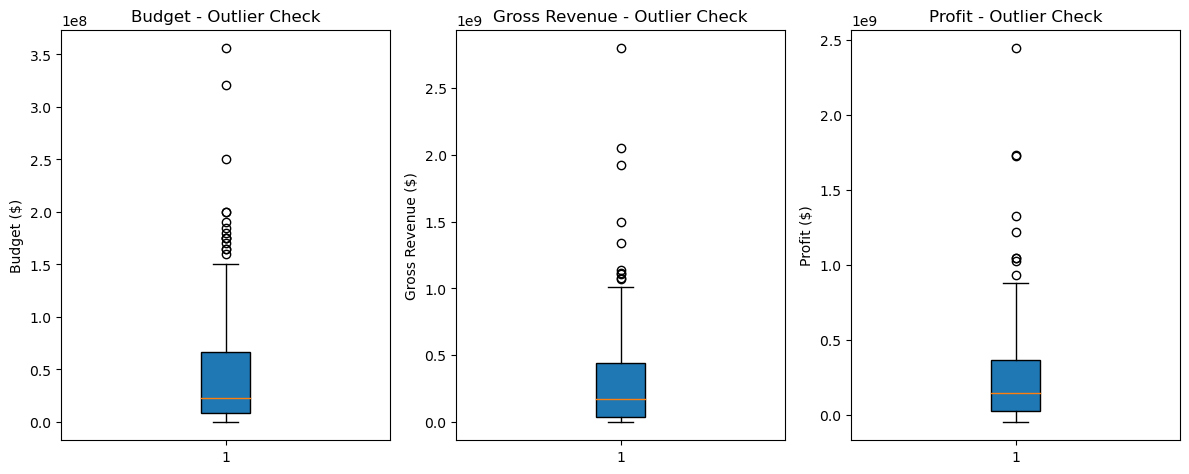

In [498]:
# Boxplots for Budget and Gross Revenue
plt.figure(figsize=(12, 5))

# Budget
plt.subplot(1, 3, 1)
plt.boxplot(df_1["Budget"], patch_artist = True)
plt.title("Budget - Outlier Check")
plt.ylabel("Budget ($)")

# Gross Revenue
plt.subplot(1, 3, 2)
plt.boxplot(df_1["Gross Revenue"], patch_artist = True)
plt.title("Gross Revenue - Outlier Check")
plt.ylabel("Gross Revenue ($)")

# Profit
plt.subplot(1, 3, 3)
plt.boxplot(df_1["Profit"], patch_artist = True)
plt.title("Profit - Outlier Check")
plt.ylabel("Profit ($)")

plt.tight_layout()
plt.show()


In [499]:
# Top 5 movies with highest budgets
df_1[["Title", "Budget"]].sort_values(by="Budget", ascending=False).head()

,Title,Budget
73,Avengers: Endgame,356000000
59,Avengers: Infinity War,321000000
70,The Dark Knight Rises,250000000
191,Spider-Man: No Way Home,200000000
92,Toy Story 3,200000000


In [500]:
# Top 5 movies with highest gross revenue
df_1[["Title", "Gross Revenue"]].sort_values(by="Gross Revenue", ascending=False).head()

,Title,Gross Revenue
73,Avengers: Endgame,2799439100
59,Avengers: Infinity War,2052415039
191,Spider-Man: No Way Home,1921426073
145,Top Gun: Maverick,1495696292
175,Harry Potter and the Deathly Hallows: Part 2,1342505340


In [501]:
# Top 5 movies with highest gross revenue
df_1[["Title", "Profit"]].sort_values(by="Profit", ascending=False).head()

,Title,Profit
73,Avengers: Endgame,2443439100
59,Avengers: Infinity War,1731415039
191,Spider-Man: No Way Home,1721426073
145,Top Gun: Maverick,1325696292
175,Harry Potter and the Deathly Hallows: Part 2,1217505340


We can compare the difference between **Budget**, **Gross Revenue**, **Profit** of top 20 movies by visualizing it in a **Line chart**.

*This includes no null values and the values are ordered by "IMDB Rating"*

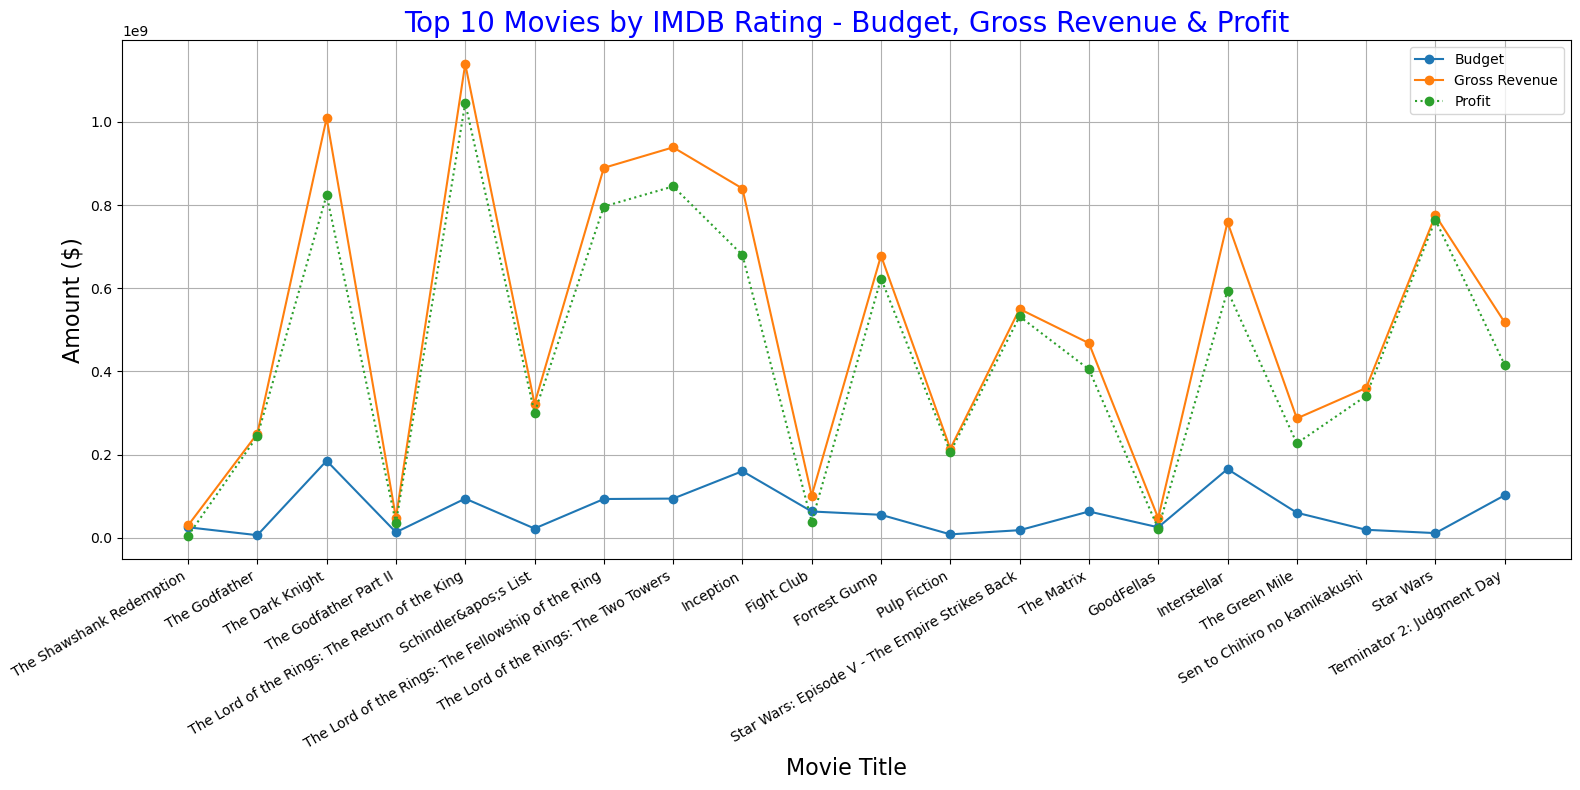

In [502]:
# Filling NaN values with 0 for visualization
top10_imdb = df_1.sort_values(by="IMDB Rating", ascending=False).head(20)

top10_imdb_viz = top10_imdb.copy()
top10_imdb_viz[["Budget", "Gross Revenue", "Profit"]] = top10_imdb_viz[["Budget", "Gross Revenue", "Profit"]].fillna(0)

# Line chart
plt.figure(figsize=(16, 8))

plt.plot(top10_imdb_viz["Title"], top10_imdb_viz["Budget"], marker="o", label="Budget")
plt.plot(top10_imdb_viz["Title"], top10_imdb_viz["Gross Revenue"], marker="o", label="Gross Revenue")
plt.plot(top10_imdb_viz["Title"], top10_imdb_viz["Profit"], marker="o", label="Profit", linestyle = 'dotted')

plt.title("Top 10 Movies by IMDB Rating - Budget, Gross Revenue & Profit", color = "blue", size = 20)
plt.xlabel("Movie Title", size = 16)
plt.ylabel("Amount ($)", size = 16)
plt.xticks(rotation = 30, ha = "right")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now we will see a **Bar charts** of top 20 movies by **IMDB Rating**, **Budget** and **Profit** for better understanding.

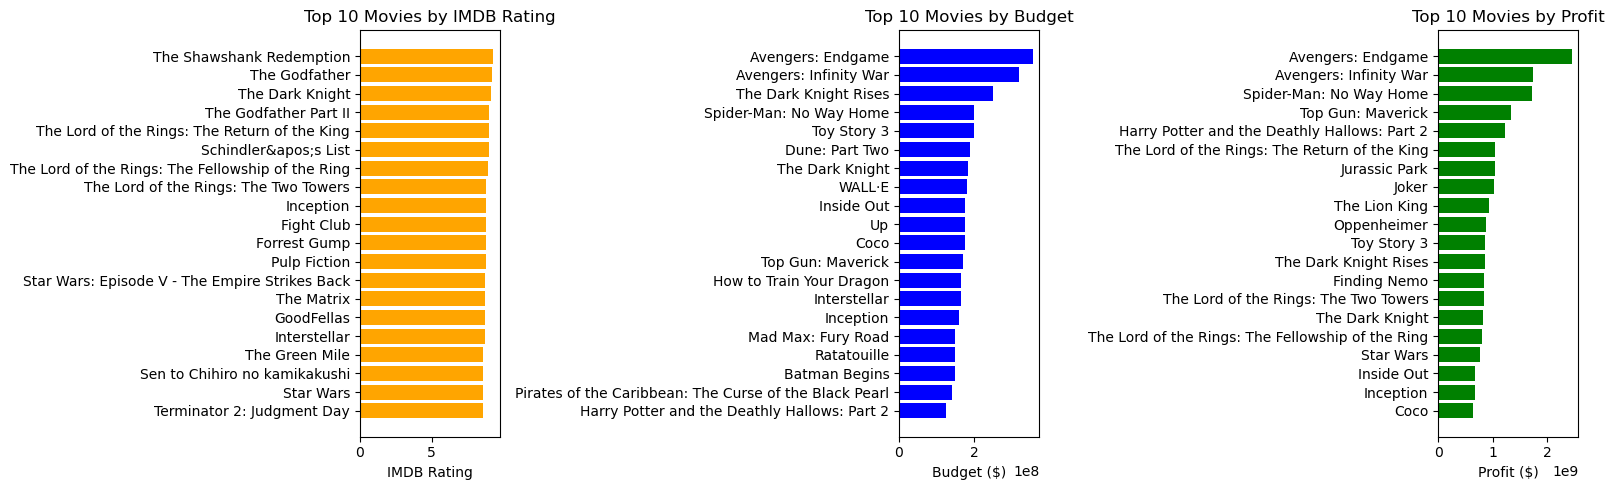

In [503]:
# Top 10 movies by Budget
top10_IMDB = df_1.sort_values(by="IMDB Rating", ascending=False).head(20)

# Top 10 movies by Profit
top10_budget = df_1.sort_values(by="Budget", ascending=False).head(20)

# Top 10 movies by Profit
top10_profit = df_1.sort_values(by="Profit", ascending=False).head(20)

plt.figure(figsize=(16, 5))

# --- Top 10 Budget ---
plt.subplot(1, 3, 1)
plt.barh(top10_IMDB["Title"], top10_IMDB["IMDB Rating"], color="orange")
plt.title("Top 10 Movies by IMDB Rating")
plt.xlabel("IMDB Rating")
plt.gca().invert_yaxis()  # Highest value on top

# --- Top 10 Gross revenue ---
plt.subplot(1, 3, 2)
plt.barh(top10_budget["Title"], top10_budget["Budget"], color="blue")
plt.title("Top 10 Movies by Budget")
plt.xlabel("Budget ($)")
plt.gca().invert_yaxis()

# --- Top 10 Profit ---
plt.subplot(1, 3, 3)
plt.barh(top10_profit["Title"], top10_profit["Profit"], color="green")
plt.title("Top 10 Movies by Profit")
plt.xlabel("Profit ($)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


Below code finds movies that rank in the **top 20** for **IMDB Rating**, **Budget**, and **Profit** at the same time.

It shows only those movies that overlap across all three categories, helping us identify the most popular, high-budget, and highly profitable movies.

The final result displays that high budget movies with high popularity can be highly profitable.

In [504]:
# Top 20 movies by each metric
df_by_IMDB = df_1.sort_values(by = "IMDB Rating", ascending = False).head(20) # IMDB Rating
df_by_budget = df_1.sort_values(by = "Budget", ascending = False).head(20) # Budget
df_by_profit = df_1.sort_values(by = "Profit", ascending = False).head(20) # Profit

# Merging all 
# Merge IMDB Rating and Budget
merge_1 = pd.merge(df_by_IMDB, df_by_budget, on = "Title", how='inner')
# Merge with Profit
final_merge = pd.merge(merge_1, df_by_profit, on = "Title", how='inner')

# Showing only relevant columns which overlap's with all the metrices
final_merge = final_merge[["Title", "IMDB Rating", "Budget", "Profit", "Director"]]
final_merge

,Title,IMDB Rating,Budget,Profit,Director
0,The Dark Knight,9.1,185000000,824242873,Christopher Nolan
1,Inception,8.8,160000000,679786473,Christopher Nolan


This concludes that only two movies **"The Dark Knight"** and **"Inception"** ranked in the top 20 for IMDB Rating, Budget, and Profit.

Both movies were directed by **Christopher Nolan**, showing his ability to create films that are highly rated by audiencesa and critics, highly profitable, and made with large production budgets.

In [505]:
df_1.head(3)

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue,Profit
0,The Shawshank Redemption,1994,9.3,3098341,Drama,A,142,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033,4334033
1,The Godfather,1972,9.2,2159397,"Crime, Drama",A,175,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198,244342198
2,The Dark Knight,2008,9.1,3073328,"Action, Crime, Drama",UA,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873,824242873


We can identify the most **financially efficient movies** : 

Movies with high **Return on Investment (ROI)** or **Budget-to-Profit Ratio**, which tells us how efficiently a movie turned its budget into profit.

There are two common ways to calculate this:
1. Return on Investment (ROI) - 
    - **ROI = (Profit / Budget) × 100**
    
    Shows how much profit was made for every dollar spent.
    Higher ROI (%) means better efficiency.

2. Budget-to-Profit Ratio - 
    - **Ratio = Budget / Profit**
    
    Lower ratio means better performance.
    Shows how much budget was needed to generate each unit of profit.

In [506]:
# We are using ROI(%) here for better understanding 

# Creating a copy of df_1 to avoid modifying the original
df_efficient_movies = df_1.copy()

# Calculate ROI (Return on Investment)
# ROI = (Profit / Budget) * 100
df_efficient_movies["ROI"] = ((df_efficient_movies["Profit"] / df_efficient_movies["Budget"]) * 100).round(2)

# Sorting movies by ROI in descending order to get the best to worst efficient movies.
df_efficient_movies = df_efficient_movies.sort_values(by="ROI", ascending=False)

# Showing top 10 most efficient movies
df_eff = df_efficient_movies[["Title", "Release year", "Budget", "Profit", "ROI", "Director"]]
df_eff.head(10)

,Title,Release year,Budget,Profit,ROI,Director
163,Gone with the Wind,2020,3977000,398405193,10017.73,Victor Fleming
28,Star Wars,1978,11000000,764398507,6949.08,George Lucas
198,Jaws,1975,7000000,483719330,6910.28,Steven Spielberg
112,Jodaeiye Nader az Simin,2012,500000,22426076,4485.22,Asghar Farhadi
1,The Godfather,1972,6000000,244342198,4072.37,Francis Ford Coppola
229,The Exorcist,1977,11000000,419872776,3817.03,William Friedkin
60,Das Leben der Anderen,2006,2000000,75672685,3783.63,Florian Henckel von Donnersmarck
244,Gekijô-ban Kimetsu no Yaiba Mugen Ressha-hen,2021,15000000,471451200,3143.01,Haruo Sotozaki
14,Star Wars: Episode V - The Empire Strikes Back,1980,18000000,532016086,2955.64,Irvin Kershner
8,Pulp Fiction,1994,8000000,205928762,2574.11,Quentin Tarantino


Visualize top 10 movies by ROI (%)

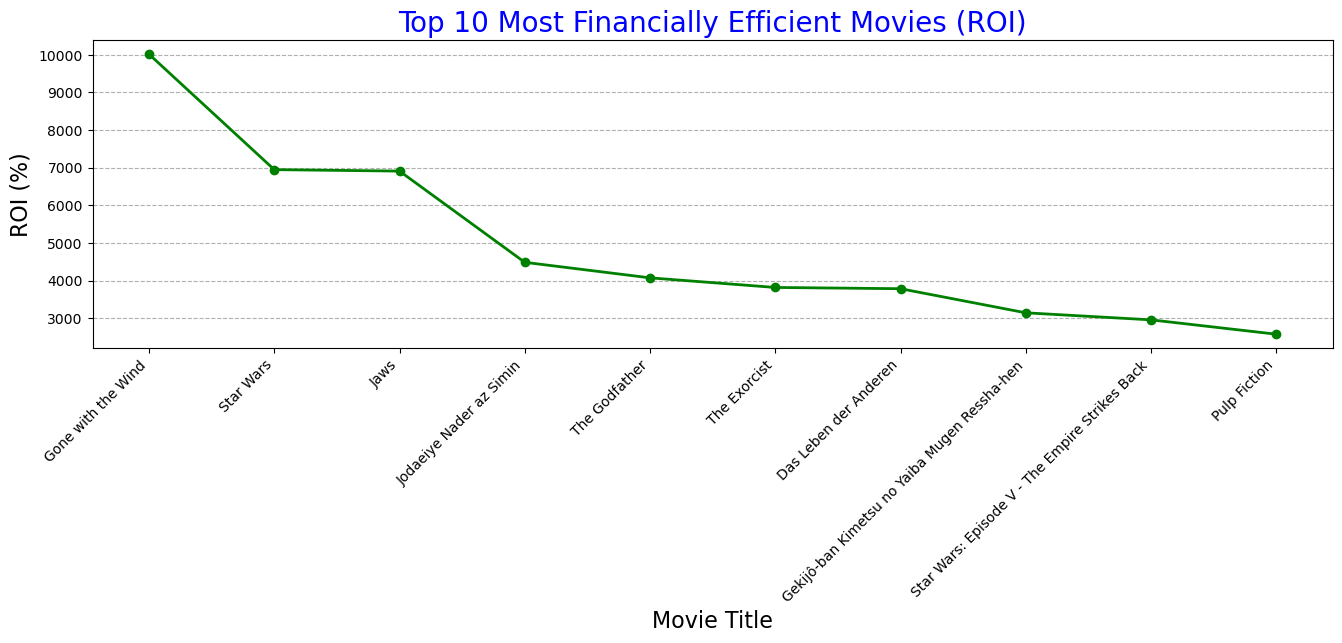

In [507]:
# Select top 10 movies based on ROI
top10_roi = df_eff.head(10)

# Plot line chart
plt.figure(figsize=(16,4))
plt.plot(top10_roi["Title"], top10_roi["ROI"], marker="o", color="green", linewidth=2, label="ROI (%)")

# Titles and labels
plt.title("Top 10 Most Financially Efficient Movies (ROI)", fontsize=20, color = "blue")
plt.xlabel("Movie Title", fontsize=16)
plt.ylabel("ROI (%)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--")

plt.show()


This concludes that the movie **"Gone with the Wind"** has the highest **Return on Investment (ROI)**.

It was released at the year of **2020** with a budget of *$ 3977000*, which was directed by **Victor Fleming**

In [513]:
# Directors with highest ROI overall
df_director_stats = df_eff.groupby("Director").agg({
    "ROI": "sum",      # Total ROI
    "Title": "count"   # Total Movies
}).reset_index().sort_values(by='ROI', ascending = False)

# Renaming the "Title" column to "Total Movies" for clarity
df_director_stats.rename(columns={"Title": "Total Movies"}, inplace=True)

# Top 10 rows by ROI
df_director_stats.head(10)

,Director,ROI,Total Movies
96,Steven Spielberg,14047.96,7
102,Victor Fleming,10840.94,2
30,George Lucas,6949.08,1
26,Francis Ford Coppola,4575.5,3
4,Asghar Farhadi,4485.22,1
79,Quentin Tarantino,3907.51,5
105,William Friedkin,3817.03,1
25,Florian Henckel von Donnersmarck,3783.63,1
39,Hayao Miyazaki,3426.27,3
65,Martin Scorsese,3171.15,7


In the above step, we grouped the dataset by directors and calculated the total **ROI (Return on Investment)** for each director.

From this we see that **Steven Spielberg** stands out with the highest **total ROI** of **14047.96 %** with **7 Movies**, indicating that his movies consistently generate excellent returns compared to their production budgets and also came under top 250 movies overall.

This makes him the most financially impactful filmmaker in the dataset.

In [524]:
df_director_stats.head(3)

,Director,ROI,Total Movies
96,Steven Spielberg,14047.96,7
102,Victor Fleming,10840.94,2
30,George Lucas,6949.08,1


Now we will compare some data using **Normalization**

**Normalization** is the process of scaling different numeric values to a common range so they can be compared fairly.

It is useful when two features have different units or scales, for example - ROI in thousands vs Number of Movies in single digits.

1. **Min-Max Normalization** (0 to 100 scale)

    Min-Max Normalization is one of the simplest methods where the values are scaled to a fixed range — usually 0 to 1.

    The formula for calculating the Min-Max Scaling is:
    
    **Normalized Value  = (X - X_min) / (X_max - X_min) * 100**

    * X is the original value.

    * X_min is the minimum value in the dataset.

    * X_max is the maximum value in the dataset

2. **Z-Score Normalization** (Standardization)

    Z-score normalization, also known as standardization, transforms data to have a mean of 0 and a standard deviation of 1. The formula is:
    
    **Z-Score = (X - μ) / σ**
    
    * X is the original value.

    * μ is the mean of the dataset.

    * σ is the standard deviation of the dataset.

Use **Min-Max** normalization when we need to scale the data to a specific range (like 0 to 1),
Use **Z-score** normalization when your data has outliers.

In [535]:
df_director_stats = df_director_stats.sort_values(by="ROI", ascending=False).head(10).copy()

# Normalizing ROI and Total Movies to 0–100 scale

min_ROI = df_director_stats["ROI"].min() # min ROI
max_ROI = df_director_stats["ROI"].max() # max ROI

min_movies = df_director_stats["Total Movies"].min() # min movies
max_movies = df_director_stats["Total Movies"].max() # max movies

# Adding "ROI_Normalized" column
df_director_stats["ROI_Normalized"] = ((df_director_stats["ROI"] - min_ROI) / (max_ROI - min_ROI) * 100).round(2)
# Adding "Movies_Normalized" column
df_director_stats["Movies_Normalized"] = ((df_director_stats["Total Movies"] - min_movies) / (max_movies - min_movies) * 100).round(2)

# Showing the data
df_director_stats

,Director,ROI,Total Movies,ROI_Normalized,Movies_Normalized
96,Steven Spielberg,14047.96,7,100.0,100.00
102,Victor Fleming,10840.94,2,70.52,16.67
30,George Lucas,6949.08,1,34.73,0.00
26,Francis Ford Coppola,4575.5,3,12.91,33.33
4,Asghar Farhadi,4485.22,1,12.08,0.00
79,Quentin Tarantino,3907.51,5,6.77,66.67
105,William Friedkin,3817.03,1,5.94,0.00
25,Florian Henckel von Donnersmarck,3783.63,1,5.63,0.00
39,Hayao Miyazaki,3426.27,3,2.35,33.33
65,Martin Scorsese,3171.15,7,0.0,100.00


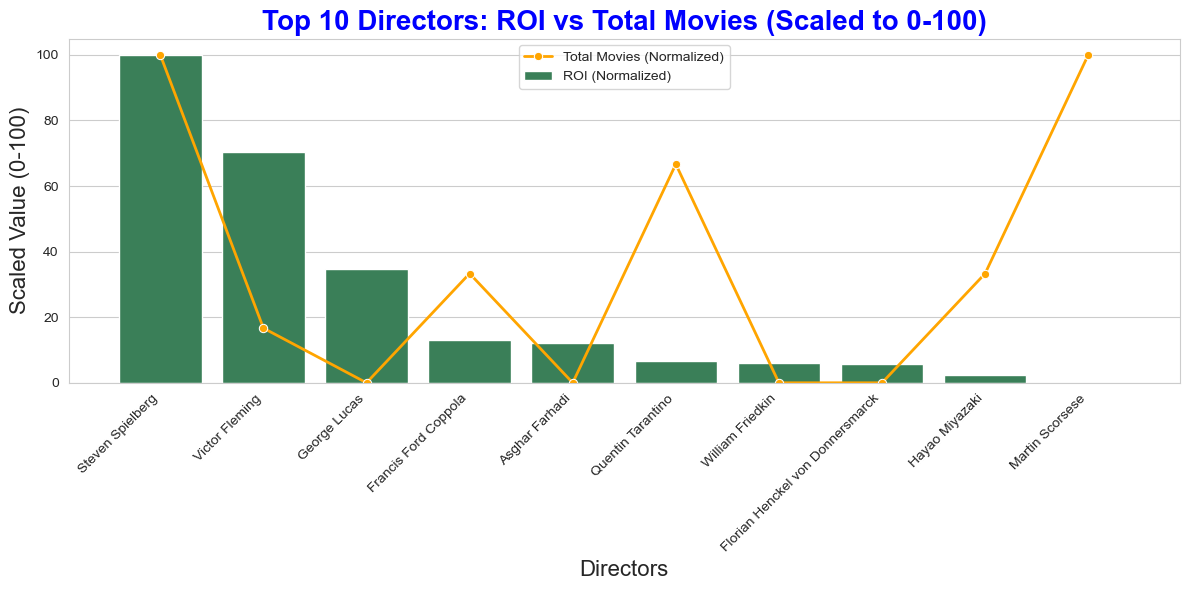

In [692]:
# Visualization
# Plot
plt.figure(figsize=(12,6))

# Bar plot for ROI_Normalized
sns.barplot(
    data = df_director_stats, 
    x = "Director", 
    y = "ROI_Normalized", 
    color = "seagreen", 
    label = "ROI (Normalized)"
)

# Line plot for Movies_Normalized
sns.lineplot(
    data = df_director_stats,
    x = "Director", 
    y = "Movies_Normalized",
    marker = "o", 
    color = "orange",
    linewidth = 2,
    label = "Total Movies (Normalized)"
)

# Labels and styling
plt.ylabel("Scaled Value (0-100)", fontsize = 16)
plt.xlabel("Directors", fontsize = 16)
plt.title("Top 10 Directors: ROI vs Total Movies (Scaled to 0-100)", fontsize = 20, fontweight = 'bold', color = "blue")
plt.xticks(rotation = 45, ha = 'right')
plt.legend()

plt.tight_layout()
plt.show()

Now We will find: Which **Genres** are most common in the dataset.

This gives a quick view of genre popularity.

In [587]:
# Curretly "Genre" is a Object type 
df_1["Genre"].info()
# we have to convert it to list type, to separate movies by different genres

<class 'pandas.core.series.Series'>
Int64Index: 171 entries, 0 to 249
Series name: Genre
Non-Null Count  Dtype 
--------------  ----- 
171 non-null    object
dtypes: object(1)
memory usage: 6.7+ KB


In [653]:
# converting "Genre" to list type

# Copy DataFrame
df_genre = df_1.copy()
# Split the "Genre" column into a list and adding ROI column
df_genre["Genre"] = df_genre["Genre"].apply(lambda x : [i.strip() for i in x.split(",")])
df_genre["ROI"] = ((df_efficient_movies["Profit"] / df_efficient_movies["Budget"]) * 100).round(2)
# Check the result
df_genre.head(3)

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue,Profit,ROI
0,The Shawshank Redemption,1994,9.3,3098341,[Drama],A,142,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033,4334033,17.34
1,The Godfather,1972,9.2,2159397,"[Crime, Drama]",A,175,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198,244342198,4072.37
2,The Dark Knight,2008,9.1,3073328,"[Action, Crime, Drama]",UA,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873,824242873,445.54


In [658]:
# Creating a dictionary to hold genre counts
genres = {}

# Looping through each list of genres
for list_of_genres in df_genre["Genre"]:
    for genre in list_of_genres:
        # Increment the count for each genre
        if genre not in genres:
            genres[genre] = 1
        else:
            genres[genre] += 1

# Check the result
print(genres)

{'Drama': 119, 'Crime': 37, 'Action': 40, 'Adventure': 52, 'Fantasy': 14, 'Biography': 21, 'History': 5, 'Romance': 14, 'Thriller': 18, 'Sci-Fi': 18, 'Mystery': 20, 'Family': 9, 'Horror': 7, 'War': 15, 'Comedy': 26, 'Animation': 21, 'Music': 3, 'Western': 3, 'Film-Noir': 1, 'Musical': 1, 'Sport': 5}


In [700]:
# Converting to DataFrame
genre_counts = pd.DataFrame(genres.items(), columns=["Genre", "Movie Count"])

# Sort by count 
genre_counts = genre_counts.sort_values(by="Movie Count", ascending=False).reset_index(drop=True)

# Show top 10
genre_counts.head(5)

,Genre,Movie Count
0,Drama,119
1,Adventure,52
2,Action,40
3,Crime,37
4,Comedy,26


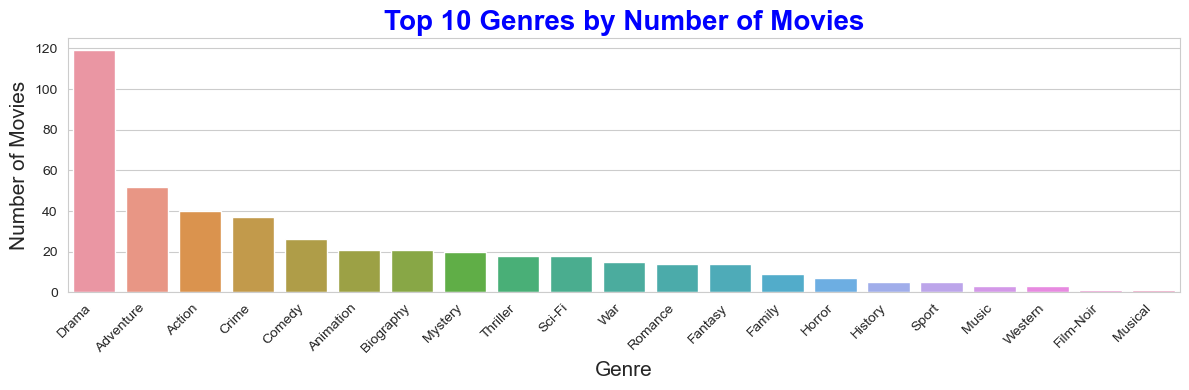

In [705]:
# Visualization with "Bar Chart"
# Plot
plt.figure(figsize = (12,4))

# Bar plot for Movie Count with Genre
sns.barplot(x = "Genre", y = "Movie Count", data = genre_counts)

# Labels and styling
plt.title("Top 10 Genres by Number of Movies", fontsize = 20, fontweight = "bold", color = "blue")
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Number of Movies", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.tight_layout()
plt.show()


This shows the number of movies created in each **Genre**.

And **Drama** is by far the highest genre with **119** movies.

Next, let's analyze **Certificates** by number of **Movies**.

In [716]:
# Count the number of movies by certificate
certificate_counts = df_1["Certificate"].value_counts().reset_index()
certificate_counts.columns = ["Certificate", "Movie Count"]

# check the result
certificate_counts

,Certificate,Movie Count
0,A,54
1,U,48
2,UA,40
3,R,11
4,PG,3
5,G,3
6,Approved,3
7,18,3
8,Not Rated,3
9,13,1


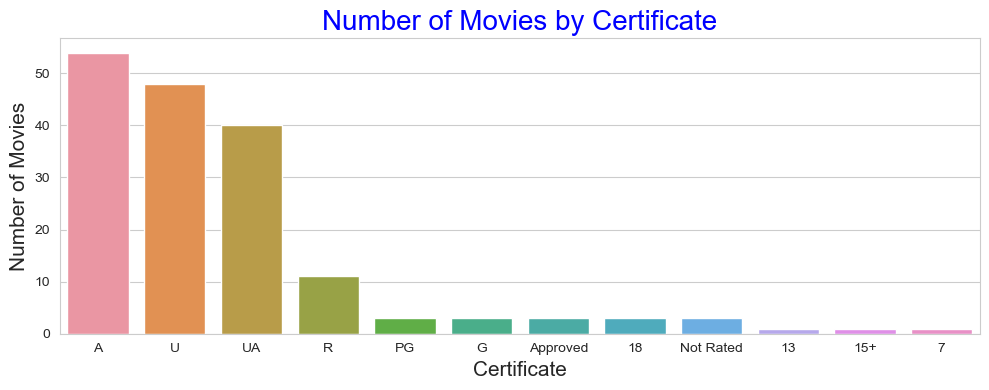

In [721]:
# Visualization with "Bar Chart"
# Plot
plt.figure(figsize=(10,4))

# Bar plot for number of Movie with Certificate
sns.barplot(x = "Certificate", y = "Movie Count", data=certificate_counts)

# Labels and styling
plt.title("Number of Movies by Certificate", fontsize = 20, color = "blue")
plt.xlabel("Certificate", fontsize = 15)
plt.ylabel("Number of Movies", fontsize = 15)
plt.tight_layout()
plt.show()

By this analysis we can clearly see that certificate category **A**, **U** and **UA** has the most movies, far more than other catagories.

So people love watching **A**, **U** and **UA** rated movies.

Next we move on to **Time Trend Analysis**, where we will answer questions like:
* How many movies are released each year per decade?
* Are IMDB ratings improving over time?
* Which decade movies has the best ROI ?

In [883]:
# setting up the dataset for analysis
# adding ROI column
df_1["ROI"] = ((df_1["Profit"] / df_1["Budget"]) * 100).round(2)
df_1.head(3)

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue,Profit,ROI,Decade
0,The Shawshank Redemption,1994,9.3,3098341,Drama,A,142,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033,4334033,17.34,1990
1,The Godfather,1972,9.2,2159397,"Crime, Drama",A,175,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198,244342198,4072.37,1970
2,The Dark Knight,2008,9.1,3073328,"Action, Crime, Drama",UA,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873,824242873,445.54,2000


How many movies are released each year per decade ?

In [884]:
# Creating a "Decade" column to get the decade
df_1["Decade"] = (df_1["Release year"] // 10) * 10
df_1[["Title", "Release year", "Decade"]].head()

,Title,Release year,Decade
0,The Shawshank Redemption,1994,1990
1,The Godfather,1972,1970
2,The Dark Knight,2008,2000
3,The Godfather Part II,1974,1970
5,The Lord of the Rings: The Return of the King,2004,2000


In [885]:
# Count of movies per decade
movies_by_decade = df_1.groupby("Decade")["Title"].count().reset_index()
movies_by_decade.columns = ["Decade", "Movie Count"]

# check the result
movies_by_decade.head(4)

,Decade,Movie Count
0,1930,3
1,1940,4
2,1950,6
3,1960,3


In [886]:
# Average IMDB Rating per decade
rating_by_decade = df_1.groupby("Decade")["IMDB Rating"].mean().round(3).reset_index()
rating_by_decade.columns = ["Decade", "Average IMDB Rating"]

# check the result
rating_by_decade.head(4)

,Decade,Average IMDB Rating
0,1930,8.367
1,1940,8.375
2,1950,8.200
3,1960,8.233


In [899]:
# Average ROI per decade
ROI_by_decade = df_1.groupby("Decade")["ROI"].mean().round(3).reset_index()
ROI_by_decade.columns = ["Decade", "Average ROI"]

# check the result
ROI_by_decade.head()

,Decade,Average ROI
0,1930,-85.907
1,1940,235.188
2,1950,164.678
3,1960,129.19
4,1970,3159.119


In [905]:
# Merging dataframes : Movies, Average IMDB Ratings and Average ROI

# merge 1
merge_1 = pd.merge(movies_by_decade, rating_by_decade, on = "Decade")

# merge 2
decade_summary = pd.merge(merge_1, ROI_by_decade, on = "Decade")

# check the result
decade_summary

,Decade,Movie Count,Average IMDB Rating,Average ROI
0,1930,3,8.367,-85.907
1,1940,4,8.375,235.188
2,1950,6,8.200,164.678
3,1960,3,8.233,129.19
4,1970,8,8.512,3159.119
5,1980,17,8.312,773.838
6,1990,27,8.437,714.514
7,2000,28,8.361,645.514
8,2010,54,8.252,596.514
9,2020,21,8.257,1355.547


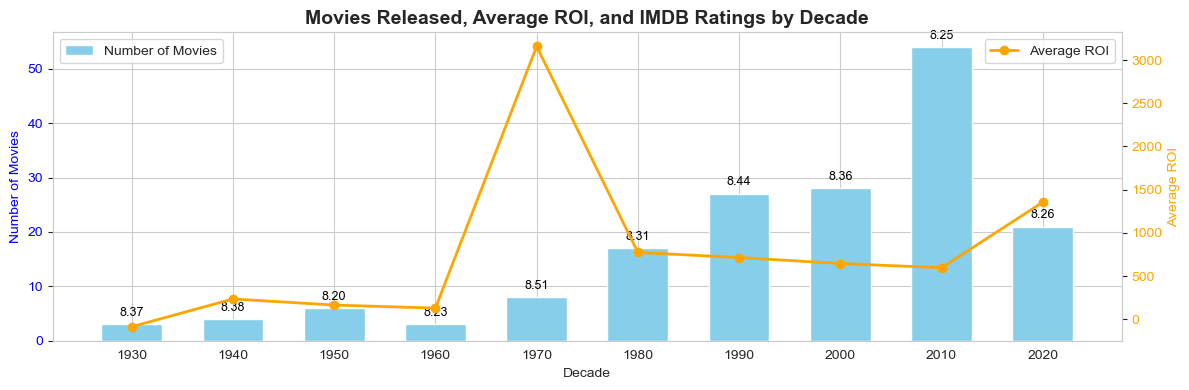

In [960]:
# Data
decades = decade_summary['Decade']
movie_counts = decade_summary['Movie Count']
avg_roi = decade_summary['Average ROI']
avg_ratings = decade_summary['Average IMDB Rating']

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,4))

# Bar plot for movie count
bars = ax1.bar(decades, movie_counts, color='skyblue', width=6, label='Number of Movies')
ax1.set_xlabel("Decade")
ax1.set_ylabel("Number of Movies", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Rotate x-axis labels to avoid overlap
plt.xticks(decades)

# Add IMDB ratings as labels above bars
for bar, rating in zip(bars, avg_ratings):
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f"{rating:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# Create second y-axis for ROI
ax2 = ax1.twinx()
ax2.plot(decades, avg_roi, color='orange', marker='o', linewidth=2, label='Average ROI')
ax2.set_ylabel("Average ROI", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title("Movies Released, Average ROI, and IMDB Ratings by Decade", fontsize=14, fontweight='bold')
fig.tight_layout()
plt.grid(False)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


From this Time Trend Analysis, we discovered that:

* The number of movies released per decade has steadily increased over time, especially after the **1980s**.

* Despite the rapid growth in movie production, the average IMDB ratings have remained relatively stable, showing consistent audience reception.

* The **1970s** stand out as the **best decade for ROI**, with an impressive **3159 % average ROI**, and also recorded the **highest average IMDB rating of 8.51**.

In [928]:
df_1.head(3)

,Title,Release year,IMDB Rating,Votes,Genre,Certificate,Runtime (min),Director,Main Cast,Budget,Gross Revenue,Profit,ROI,Decade
0,The Shawshank Redemption,1994,9.3,3098341,Drama,A,142,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton",25000000,29334033,4334033,17.34,1990
1,The Godfather,1972,9.2,2159397,"Crime, Drama",A,175,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan",6000000,250342198,244342198,4072.37,1970
2,The Dark Knight,2008,9.1,3073328,"Action, Crime, Drama",UA,152,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",185000000,1009242873,824242873,445.54,2000


The last step is a **Correlation Heatmap** to show relationships between key numerical columns such as:

**IMDB Rating, Budget, Gross Revenue, Profit, ROI**

In [936]:
# Selecting only numeric columns
numeric_cols = df_1[['IMDB Rating', 'Budget', 'Gross Revenue', 'Profit', 'ROI']]
numeric_cols.head()

,IMDB Rating,Budget,Gross Revenue,Profit,ROI
0,9.3,25000000,29334033,4334033,17.34
1,9.2,6000000,250342198,244342198,4072.37
2,9.1,185000000,1009242873,824242873,445.54
3,9.0,13000000,48005720,35005720,269.27
5,9.0,94000000,1139427855,1045427855,1112.16


In [938]:
# Calculate correlation matrix
correlation_matrix = numeric_cols.corr()
correlation_matrix

,IMDB Rating,Budget,Gross Revenue,Profit,ROI
IMDB Rating,1.000000,0.106563,0.168395,0.173185,0.089856
Budget,0.106563,1.000000,0.827168,0.769758,-0.164529
Gross Revenue,0.168395,0.827168,1.000000,0.995435,0.157977
Profit,0.173185,0.769758,0.995435,1.000000,0.207393
ROI,0.089856,-0.164529,0.157977,0.207393,1.000000


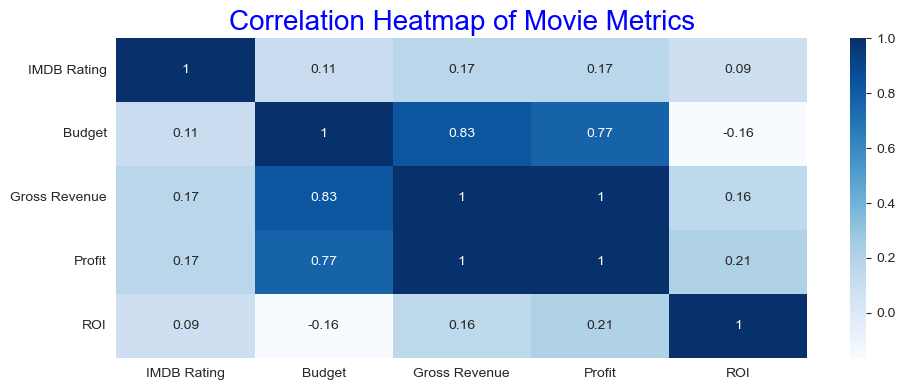

In [955]:
# Ploting Heatmap
plt.figure(figsize = (10,4))
sns.heatmap(correlation_matrix, annot = True, cmap = "Blues")

plt.title("Correlation Heatmap of Movie Metrics", fontsize = 20, color = "blue")
plt.tight_layout()
plt.show()

## Delivering a clean, structured dataset and actionable Insights & Observations.

**Actionable Insights & Observations :**

After performing Exploratory Data Analysis (EDA) on the IMDB Top 250 Movies dataset, here are the key takeaways:

---

1. Top Directors
    - Certain directors consistently produce **high ROI movies**, making them ideal benchmarks for production strategies.  
    - Example: Directors like *Christopher Nolan* and *Steven Spielberg* appear multiple times, showing their strong box-office success.

**Actionable Insight:**  
Studios can analyze these directors' approaches and genres to guide **future movie investments**.

2. Genre Analysis
    - **Drama** and **Adventure** are the **most common genres**, followed by **Action** and **Crime**.  
    - **Drama** is by far the highest genre with 119 movies.
    
**Actionable Insight:**  
Focus on producing **Drama + Adventure hybrids** for higher box-office reach, while **Animation** can be targeted for **critical acclaim** and niche audiences.

3. Certificates / Age Ratings
    - Most movies are rated **A**, followed by **U** and **UA**.  

**Actionable Insight:**  
Investing in **A -certified films** could maximize reach while keeping quality standards high.


4. Time Trend Analysis
    - A **steady increase** in the number of movies released over the years was observed.  
    - Average IMDB ratings have remained **relatively stable**, indicating consistent audience standards.
    - **1970 s** has the best **ROI** and "IMDB Rating" compare to other decades.

**Actionable Insight:**  
Recent decades show **more commercial films** being produced, suggesting the need for **data-driven marketing strategies**.


5. Correlation Heatmap
    - **Budget and Gross** Revenue are strongly correlated (0.83), indicating that **higher investment often leads to higher revenue**. 
    - **Profit and ROI** are not strongly correlated (0.21), showing that a **higher profit doesn’t always mean a higher return on investment**.
    - **IMDB Rating** has **low correlation** with financial metrics, proving that **critical acclaim doesn't always equal box office success**.

**Actionable Insight:**  
Studios should **balance budget allocation** with marketing efforts instead of relying only on critical ratings for success.

---
**Overall Summary**
- **Drama** dominates the IMDB Top 250; Adventure, Action, and Crime are also common. 
- Directors with **consistent high ROI** should be prioritized for blockbuster projects.  
- A / UA / U (family-friendly) certifications reach the widest audience and are safer commercial bets.  
- Budget decisions must be **ROI-driven**, not just based on star cast or critical reception.

---

These insights can help **production houses**, **investors**, and **streaming platforms** make **data-informed decisions** for future projects.
